# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how easy is to port the [PyMC](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [Bambi](https://bambinos.github.io/bambi/main/index.html) using the more concise formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

In [2]:
az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2

## Read Data

Let us load the data into a pandas data frame.

In [3]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Get city data
city_df = pd.read_csv(pm.get_data("cty.dat"))

In [4]:
display(radon_df.head())
print(radon_df.shape[0])

idnum state state2  stfips    zip  region  typebldg  floor  room basement  \
0      1    AZ     AZ       4  85920       1         1      1     2        N   
1      2    AZ     AZ       4  85920       1         0      9     0            
2      3    AZ     AZ       4  85924       1         1      1     3        N   
3      4    AZ     AZ       4  85925       1         1      1     3        N   
4      5    AZ     AZ       4  85932       1         1      1     1        N   

   ... stoptm startdt  stopdt activity  pcterr       adjwt  dupflag  zipflag  \
0  ...   1100  112987  120287      0.3     0.0  136.060971        0        0   
1  ...    700   70788   71188      0.6    33.3  128.784975        0        0   
2  ...   1145   70788   70788      0.5     0.0  150.245112        0        0   
3  ...   1900   52088   52288      0.6    97.2  136.060971        0        0   
4  ...    900   70788   70788      0.3     0.0  136.060971        0        0   

   cntyfips                county  
0         1  APACHE                
1         1  APACHE                
2         1  APACHE                
3         1  APACHE                
4         1  APACHE                

[5 rows x 25 columns]

12777


In [5]:
display(city_df.head())
print(city_df.shape[0])

stfips  ctfips  st      cty     lon     lat     Uppm
0       1       1  AL  AUTAUGA -86.643  32.534  1.78331
1       1       3  AL  BALDWIN -87.750  30.661  1.38323
2       1       5  AL  BARBOUR -85.393  31.870  2.10105
3       1       7  AL     BIBB -87.126  32.998  1.67313
4       1       9  AL   BLOUNT -86.568  33.981  1.88501

3194


## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [6]:
# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter to keep observations for "MN" state only
df = radon_df[radon_df.state == "MN"].copy()
city_mn_df = city_df[city_df.st == "MN"].copy()

# Compute fips
df["fips"] = 1_000 * df.stfips + df.cntyfips
city_mn_df["fips"] = 1_000 * city_mn_df.stfips + city_mn_df.ctfips

# Merge data
df = df.merge(city_mn_df[["fips", "Uppm"]], on="fips")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Compute log of Uranium
df["log_u"] = np.log(df["Uppm"])

# Let's map floor. 0 -> Basement and 1 -> Floor
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# sort values by floor
df = df.sort_values(by="floor")
# Reset index
df = df.reset_index(drop=True)

## EDA

Let us do some exploratory data analysis. To get a glimpse of the data we are going to use. First Let us see global `log_radon` distribution.

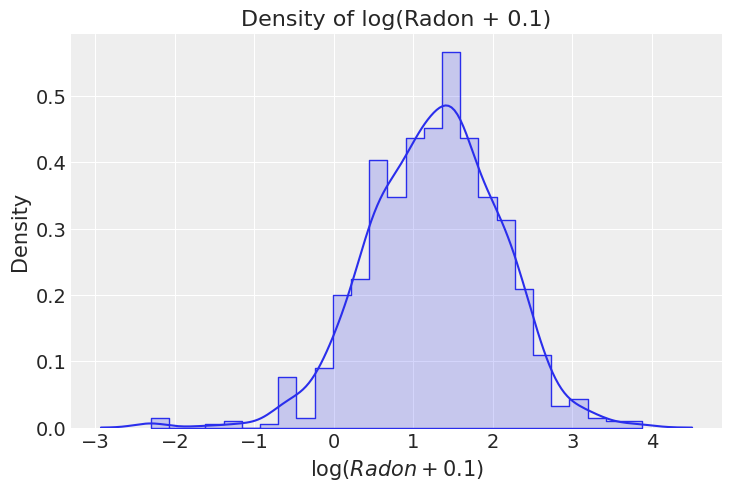

In [7]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", alpha=0.2, stat="density", element="step", common_norm=False, data=df, ax=ax)
sns.kdeplot(x="log_radon", data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log(Radon + 0.1)$", ylabel="Density");

Let us now split per the distribution of `log(radon + 0.1)` per `floor`:

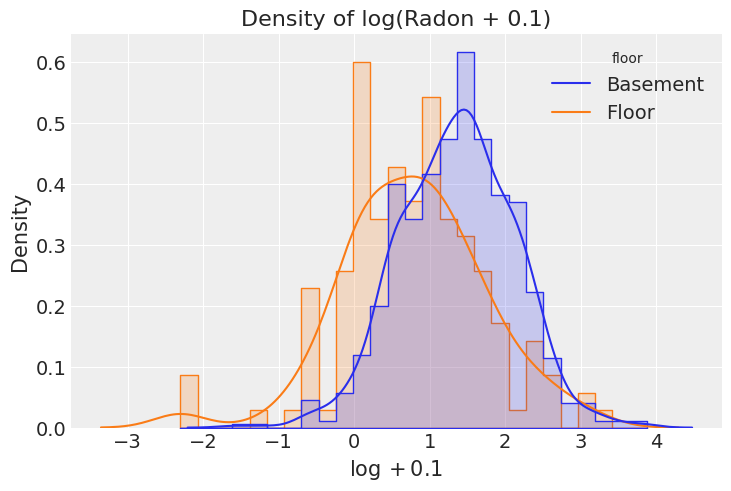

In [8]:
fig, ax = plt.subplots()
sns.histplot(
    x="log_radon", hue="floor", alpha=0.2, stat="density", element="step", 
    common_norm=False, data=df, ax=ax
)
sns.kdeplot(x="log_radon", hue="floor", common_norm=False, data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log + 0.1$", ylabel="Density");

Note that the `Basement` distribution is shifted to the right with respect to the `Floor` distribution. This exploration tells us the average radon level is higher in Basement than Floor.

Next, let us count the number of counties.

In [9]:
n_counties = df["county"].unique().size
print(f"Number of counties: {n_counties}")

Number of counties: 85


Let us dig deeper into the distribution of radon per county and floor level.

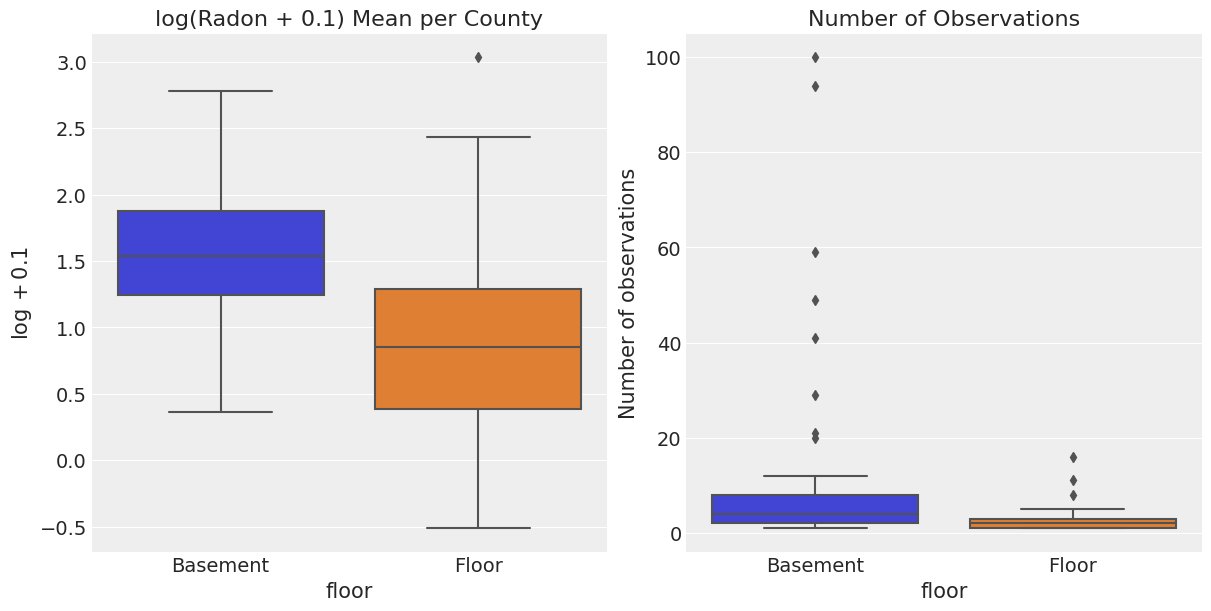

In [10]:
log_radon_county_agg  = (
    df 
    .groupby(["county", "floor"], as_index=False)
    .agg(
        log_radon_mean=("log_radon", "mean"),
        n_obs=("log_radon", "count")
    )
)

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout="constrained")
sns.boxplot(x="floor", y="log_radon_mean", data=log_radon_county_agg, ax=ax[0])
ax[0].set(title="log(Radon + 0.1) Mean per County", ylabel="$\log + 0.1$")

sns.boxplot(x="floor", y="n_obs", data=log_radon_county_agg, ax=ax[1])
ax[1].set(title="Number of Observations", xlabel="floor", ylabel="Number of observations");

- On the left hans side we can see that the `Basement` distribution per county is shifted to the right with respect to the `Floor` distribution. We had seen this above when considering all counties together.
- On the right hand side we see that the number of observations per county is not the same for the `floor` levels. In particular, we see that there are some counties with a lot of basement observations. This can create some bias when computing simple statistics to compare across counties. Moreover, not all `county` and `floor` combinations are present in the dataset. For example:

In [11]:
assert df.query("county == 'YELLOW MEDICINE' and floor == 'Floor'").empty

## Models: Conventional Approaches

### Complete Pooling

#### Model

For this first model we only consider the predictor `floor`, which represents the floor level. The following equation describes the linear model that we are going to build with Bambi

$$
y_{i} = \beta_{j[i]} + \varepsilon_i
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\beta_{j[i]} &= \text{Intercept for the Floor level } j \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

Each $j$ indexes a different floor level. In this case, $j=1$ means Basement and $j=2$ means Floor.

#### Priors

##### Common effects

The only common effect in this model is the Floor effect represented by the $\beta_{j[i]}$ coefficients. We have

$$
\begin{array}{lr}
\beta_{j[i]} \sim \text{Normal}(0, \sigma_\beta) & \text{for all } j:1, 2
\end{array}
$$

where $\sigma_\beta$ is a positive constant that we set to 10. 

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

 where $\lambda$ is a positive constant that we set to 1. 

#### Notes

* The notation $j[i]$ means that the Floor level $j$ depends on the measurement $i$ we're looking at. Each measurement $i$ is tied to one, and only one Floor level.

Let us now write the Bambi model:

In [12]:
# A dictionary with the priors we pass to the model initialization
pooled_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

pooled_model = bmb.Model("log_radon ~ 0 + floor", df, priors=pooled_priors)
pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

The `0` on the right side of `~` in the model formula removes the intercept that is added by default. This allows Bambi to use one coefficient for each floor level.

In the message when we print the model `Family name: Gaussian` and `Link: identity` indicate the default values for the `family` and `link` arguments in `bmb.Model()`. It simply means this is a normal linear regression model.

Let's now fit the model.

In [13]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Let us see the graph representation of the model:

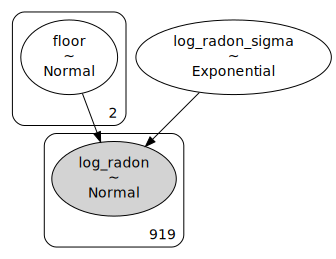

In [14]:
pooled_model.graph()

Now we can examine the posterior distribution of the model parameters:

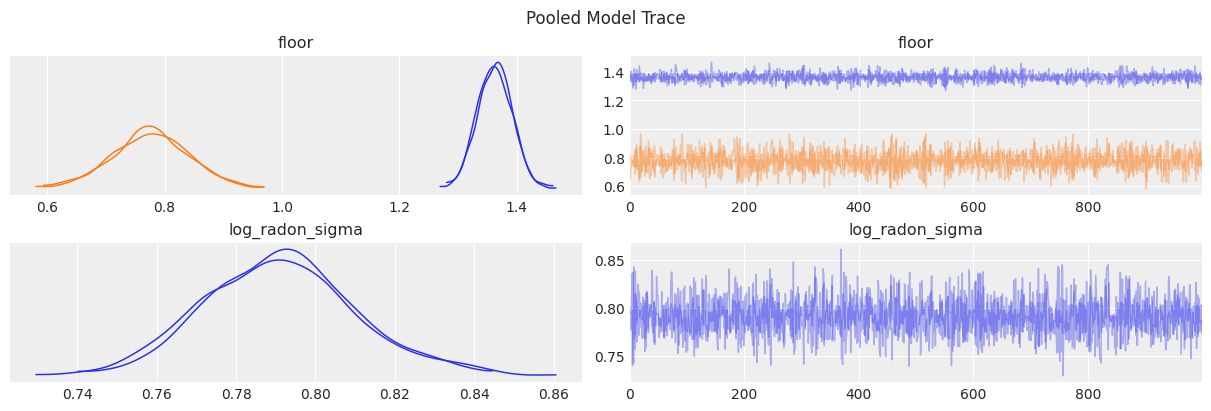

In [15]:
az.plot_trace(data=pooled_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Pooled Model Trace");

We can now see some posterior summary statistics.

In [16]:
pooled_summary = az.summary(data=pooled_results)
pooled_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
floor[Basement]  1.363  0.030   1.309    1.419      0.001    0.000    3122.0   
floor[Floor]     0.776  0.066   0.654    0.908      0.001    0.001    2786.0   
log_radon_sigma  0.791  0.019   0.756    0.828      0.000    0.000    2439.0   

                 ess_tail  r_hat  
floor[Basement]    1458.0    1.0  
floor[Floor]       1043.0    1.0  
log_radon_sigma    1275.0    1.0

From the posterior plot and the summary, we can see the mean radon level is considerably higher in the Basement than in the Floor level. This reflects what we originally saw in the initial data exploration.

We can compare the mean of the posterior distribution of the `floor` terms to the sample mean. This is going to be useful to understand the meaning of **complete pooling**.

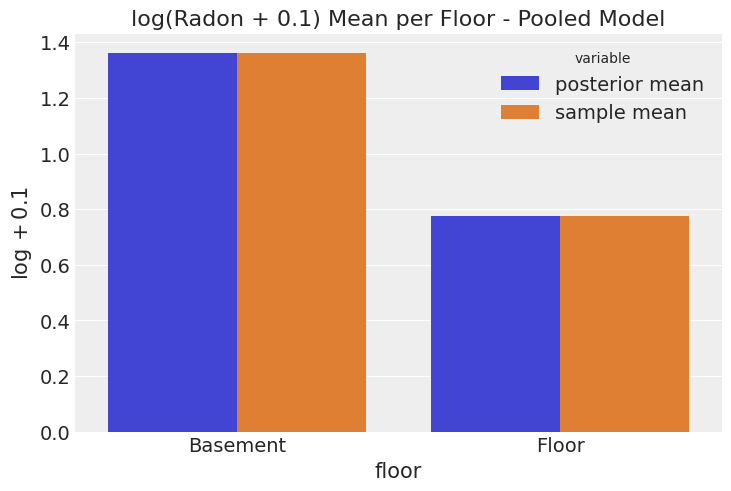

In [17]:
fig, ax = plt.subplots()

(
    pooled_summary["mean"]
    .iloc[:-1]
    .reset_index()
    .assign(floor = lambda x: x["index"].str.slice(6, -1).str.strip())
    .merge(
        right=df.groupby(["floor"])["log_radon"].mean(),
        left_on="floor",
        right_index=True
    )
    .rename(columns={
        "mean": "posterior mean",
        "log_radon": "sample mean"
    })
    .melt(
        id_vars="floor",
        value_vars=["posterior mean", "sample mean"]
    )
    .pipe((sns.barplot, "data"),
        x="floor",
        y="value",
        hue="variable",
        ax=ax
    )
)
ax.set(title="log(Radon + 0.1) Mean per Floor - Pooled Model", ylabel="$\log + 0.1$");

From the plot alone it is hard to detect the difference between the posterior mean and the sample mean. That is because the estimation for the observations in either group is simply the group mean plus the smoothing because of the non-flat priors. 

In other words, for every observation in Basement the model predicts the mean radon for all the Basement measurements, and for every observation in Floor the model predicts the mean radon for all the Floor measurements.

**What does the _complete pooling_ exactly mean here?**

In this example, the pooling refers to how we treat the different Counties when computing estimates (i.e. this does not refer to pooling across floor levels for example). _Complete pooling_ means that all the measurements for all Counties are pooled into a single estimate ("treat all counties the same"), conditional on the floor level (because we are using floor as a covariate/predictor). For that reason, when computing the prediction for a certain observation we do not discriminate which County it belongs to, we pool all the counties into a single estimate, i.e., we perform a complete pooling.

Let's now compare the posterior predictive distribution for each group with the distribution of the observed data.

To do this we need to perform a couple of steps:

- Obtain samples from the posterior predictive distribution using the `.predict()` method.
- Apply the inverse transform to have the posterior predictive samples in the original scale of the response.

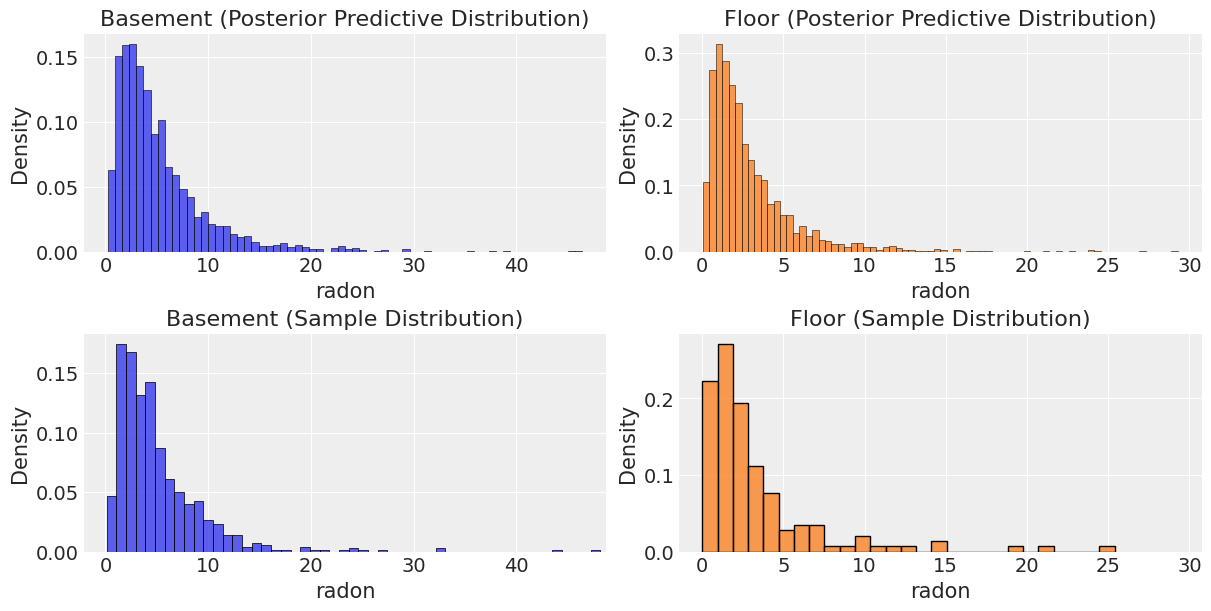

In [18]:
# Note we create a new data set. 
# One observation per group is enough to obtain posterior predictive samples for that group
new_data = pd.DataFrame({"floor": ["Basement", "Floor"]})
pooled_model.predict(pooled_results, kind="pps", data=new_data)

# Stack chains and draws and extract posterior predictive samples
pps = pooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

# Inverse transform the posterior predictive samples
pps = np.exp(pps) - 0.1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), layout="constrained")
ax = ax.flatten()

sns.histplot(x=pps[0].flatten(), stat="density", color="C0", ax=ax[0])
ax[0].set(title="Basement (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density")
sns.histplot(x="activity", data=df.query("floor == 'Basement'"), stat="density", ax=ax[2])
ax[2].set(title="Basement (Sample Distribution)", xlim=ax[0].get_xlim(), xlabel="radon", ylabel="Density")

sns.histplot(x=pps[1].flatten(), stat="density", color="C1", ax=ax[1])
ax[1].set(title="Floor (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density")
sns.histplot(x="activity", data=df.query("floor == 'Floor'"), stat="density", color="C1", ax=ax[3])
ax[3].set(title="Floor (Sample Distribution)", xlim=ax[1].get_xlim(), xlabel="radon", ylabel="Density");

The distributions look very similar, but we see that we have some extreme values, hence if we need a number to compare them let us use the median.

In [19]:
np.median(a=pps, axis=1)

array([3.90955069, 2.05970487])

In [20]:
df.groupby(["floor"])["activity"].median()

floor
Basement    3.9
Floor       2.1
Name: activity, dtype: float64

### No Pooling

This model has both Floor and Country as predictors. They are represented with an interaction effect. This means the predicted radon level for a given measurement depends both on the Floor level as well as the County. This interaction coefficient allows the Floor effect to vary across Counties. Analogously, it is equivalent to say the effect of County can vary across Floor levels.

#### Model

$$
y_{i} = \gamma_{jk[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\gamma_{jk[i]} &= \text{Intercept for Floor level } j \text{ and County } k\\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$


#### Priors

##### Common effects

The common effect in this model is the interaction between Floor and County. The prior is

$$
\gamma_{jk[i]} \sim \text{Normal}(0, \sigma_\gamma)
$$

for all $j: 1, 2$ and $k: 1, \cdots, 85$.  
$\sigma_\gamma$ is a positive constant that we set to 10.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$
where $\lambda$ is a positive constant that we set to 1.


The notation $jk[i]$ means the Floor level $j$ and County $k$ both depend on the measurement $i$ we're looking at. As in the previous example, this is because each measurement $i$ is tied to a unique combination of County and Floor.

To specify this model in Bambi we can use the formula `log_radon ~ 0 + county:floor`. Again, we remove the intercept with the `0` on the right hand side. `county:floor` specifies the multiplicative interaction between `county` and `floor`.

In [21]:
unpooled_priors = {
    "county:floor": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

unpooled_model = bmb.Model("log_radon ~ 0 + county:floor", df, priors=unpooled_priors)
unpooled_model

Formula: log_radon ~ 0 + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county:floor ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [22]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


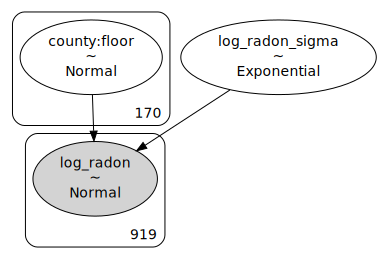

In [23]:
unpooled_model.graph()

From the graph representation of the model we see the model estimates $170 = 85 \times 2$ parameters for the `county:floor` interaction. Let us now explore the model fit.

First, We can now see the plot of the marginal posterior distributions along with the sampling traces.

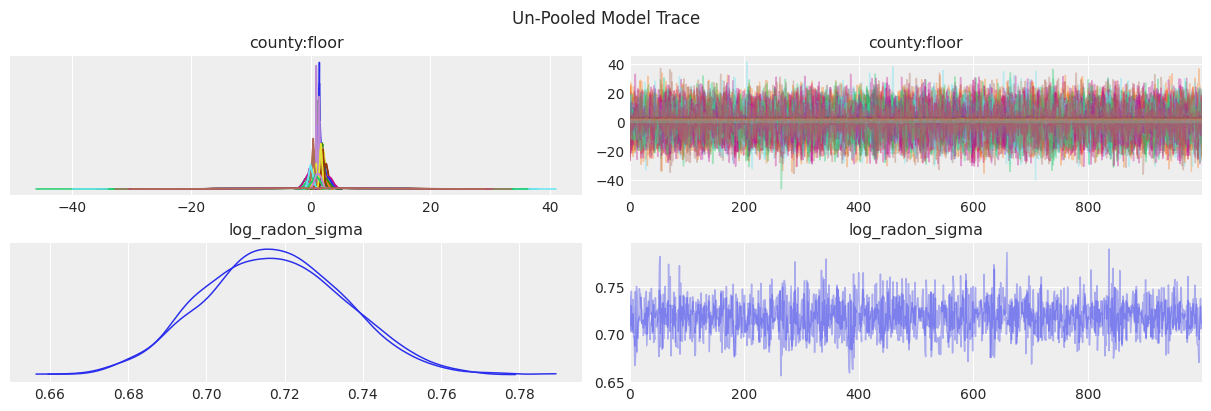

In [24]:
az.plot_trace(data=unpooled_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Un-Pooled Model Trace");

Some posteriors for `county:floor` are much more spread than others, which makes it harder to compare them. To obtain a better summary visualization we can use a forest plot. This plot also allows us to identify exactly the combination of `county` and `floor` level.

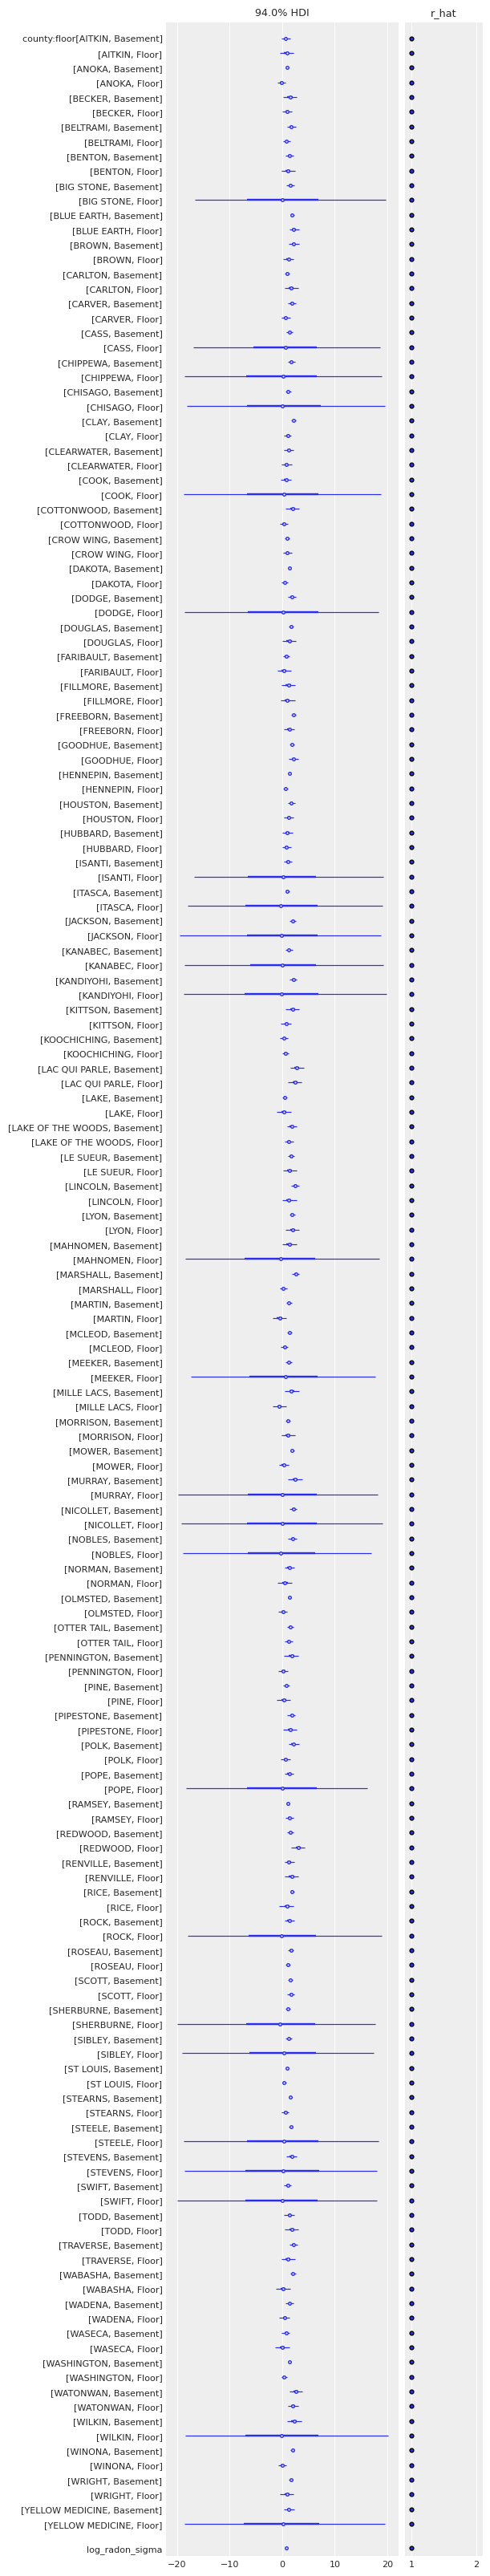

In [26]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Note how for the combination `county == 'YELLOW MEDICINE' and floor == 'Floor'` where we do not have any observations, the model can still generate predictions which are essentially coming from the prior distributions, which explains the large HDI intervals.

Next let us look into the posterior mean for each `county` and `floor` combination:

In [27]:
unpooled_summary = az.summary(data=unpooled_results)

We can now plot the posterior distribution mean of the beta coefficients against the observed values (sample).

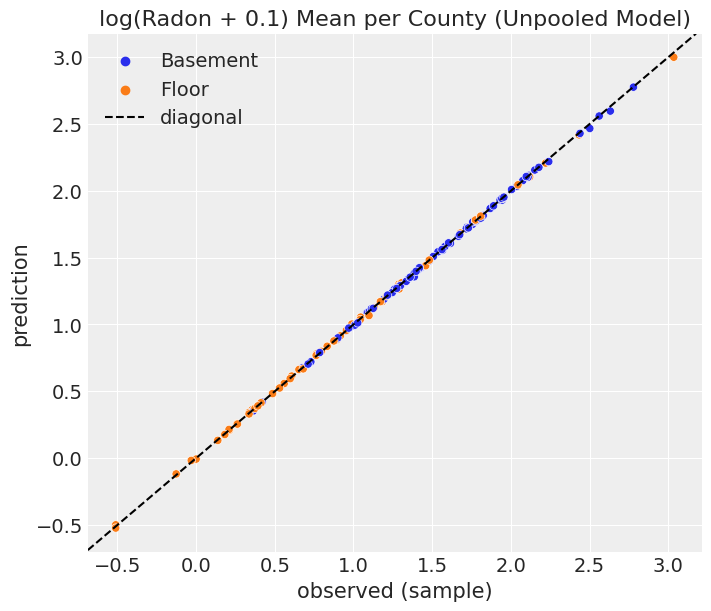

In [28]:
# Get county and floor names from summary table
var_mapping = (
    unpooled_summary
    .iloc[:-1]
    .reset_index(drop=False)["index"].str.slice(13, -1).str.split(",").apply(pd.Series)
)

var_mapping.rename(columns={0: "county", 1: "floor"}, inplace=True)
var_mapping["county"] = var_mapping["county"].str.strip()
var_mapping["floor"] = var_mapping["floor"].str.strip()
var_mapping.index = unpooled_summary.iloc[:-1].index
    
# Merge with observed values
unpooled_summary_2 = pd.concat([var_mapping, unpooled_summary.iloc[:-1]], axis=1)

fig, ax = plt.subplots(figsize=(7, 6))

(
    unpooled_summary_2
    .merge(right=log_radon_county_agg, on=["county", "floor"], how="left")
    .pipe(
        (sns.scatterplot, "data"),
        x="log_radon_mean",
        y="mean",
        hue="floor",
        ax=ax
    )
)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="log(Radon + 0.1) Mean per County (Unpooled Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
);

As expeced, the values strongly concentrated along the diagonal. In other words, for each county and floor level combination, the model uses their sample mean of radon level as prediction, plus smoothing due to the non-flat priors.

**What does the _no pooling_ exactly mean here?**

In the previous example we said that _complete pooling_ means that the observations where pooled together into single estimates no matter the County they belong to. The situation is completely the opposite in this _no pooling_ scenario. Here, none of the measurements in a given County affect the computation of the coefficient for another County. That's why, in the end, the estimation for each combination of County and Floor level (i.e. $\gamma_{jk[i]}$) is the mean of the measurements in that County and Floor level (plus prior smoothing) as is reflected in the diagonal scatterplot above.

## Hierarchical models

In this section we are going to explore various types of hierarchical models. If you're familiar with the PyMC way of using hierarchies, the Bambi way (borrowed from mixed effects models way) may be a bit unfamiliar in the beginning, but as we will see, the notation is very convenient. A good explanation is found in Chapter 16 from Bayes Rules book, specifically section 16.3.2. Moreover, you can also take a look into the [Bambi examples section](https://bambinos.github.io/bambi/main/examples.html) where you can find other use cases.

### Varying intercepts without predictors

We start with a model that considers a global intercept and varying intercepts for each County. The dispersion parameter of the prior for these varying intercepts is an _hyperprior_ that is common to all the Counties. As we are going to conclude below, this is what causes the **partial pooling** in the model estimates.


#### Model

Let us use greek letters for common effects and roman letters for varying effects. In this case, $\alpha$ is a common intercept and $u$ is a group-specific intercept. 

$$
y_{i} = \alpha + u_{j[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\alpha &= \text{Intercept common to all measurements} \\
u_{j[i]} &= \text{Intercept specific to the County } j \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$


#### Priors

##### Common effects

The only common effect in this model is the intercept $\alpha$. We have

$$
\alpha \sim \text{Normal}(0, \sigma_\alpha)
$$

where $\sigma_\alpha$ is a positive constant that we set to 10.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1.

##### Group-specific effects

$$
\begin{array}{lr}
u_{j[i]} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85
\end{array}
$$

Contrary to the common effects case, $\sigma_u$ is considered a random variable. 

We assign $\sigma_u$ the following hyperprior, which is the same to all the counties,

$$
\sigma_u \sim \text{Exponential}(\tau)
$$

and $\tau$ is a positive constant that we set to $1$.

#### Notes


The common intercept $\alpha$ represents the mean response across all Counties and Floor levels. 

On top of it, the County-specific intercept terms $u_{j[i]}$ represents deviations from that global mean specific to each County $j$. This type of terms is also known as a vaying intercept in the statistical literature.

In [29]:
# We can add the hyper-priors inside the prior dictionary parameter of the model constructor
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

partial_pooling_model = bmb.Model(
    formula="log_radon ~ 1 + (1|county)", 
    data=df, 
    priors=partial_pooling_priors, 
    noncentered=False
)
partial_pooling_model

Formula: log_radon ~ 1 + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

The `noncentered` argument asks Bambi not to use the non centered representation for the varying effects. This makes the graph representation clearer and is closer to the original implementation in the PyMC documentation.

In [30]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can inspect the graphical representation of the model:

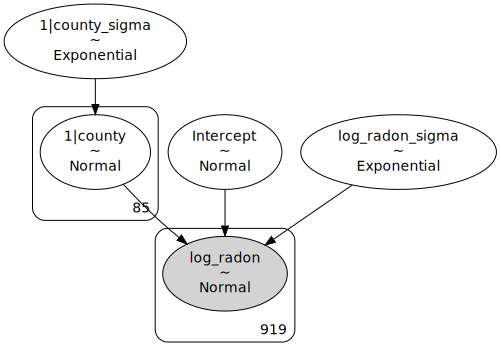

In [31]:
partial_pooling_model.graph()

We can clearly see a new hierarchical level as compared to the complete pooling model and unpooled model.

Next, we can plot the posterior distribution of the intercepts:

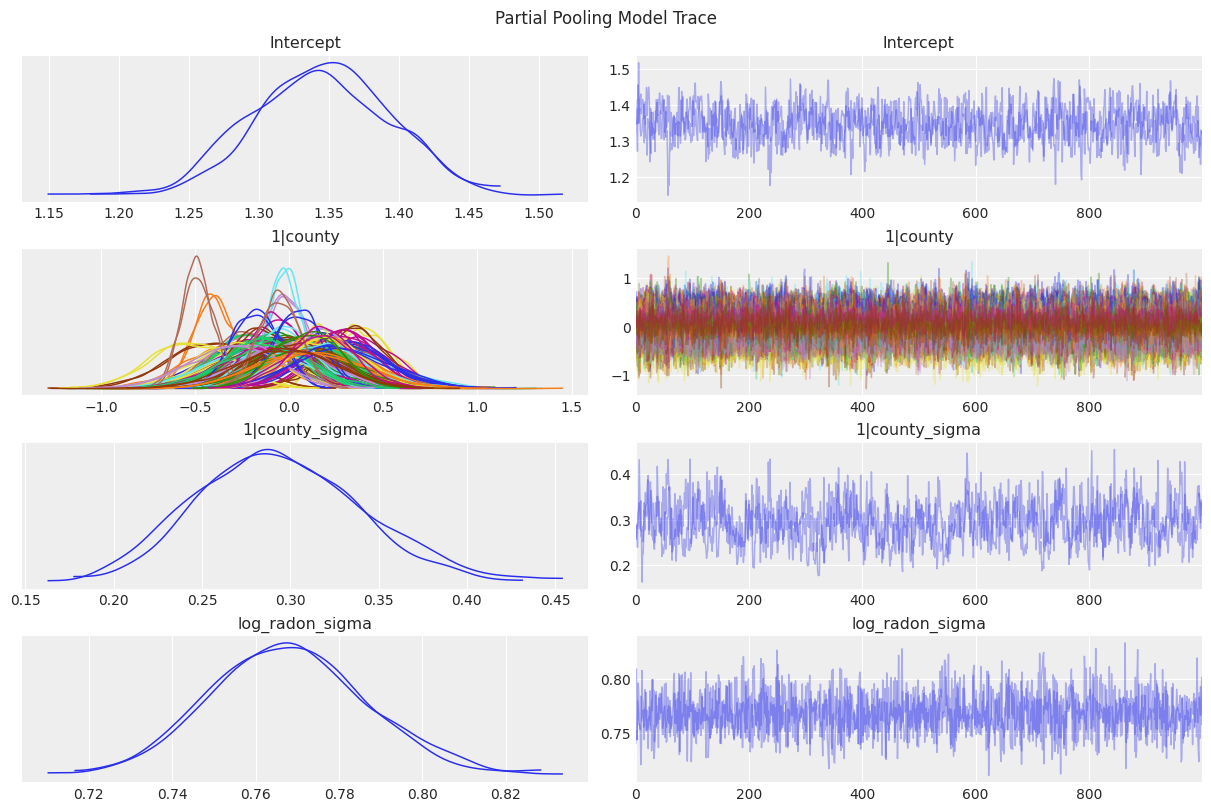

In [32]:
az.plot_trace(data=partial_pooling_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Partial Pooling Model Trace");

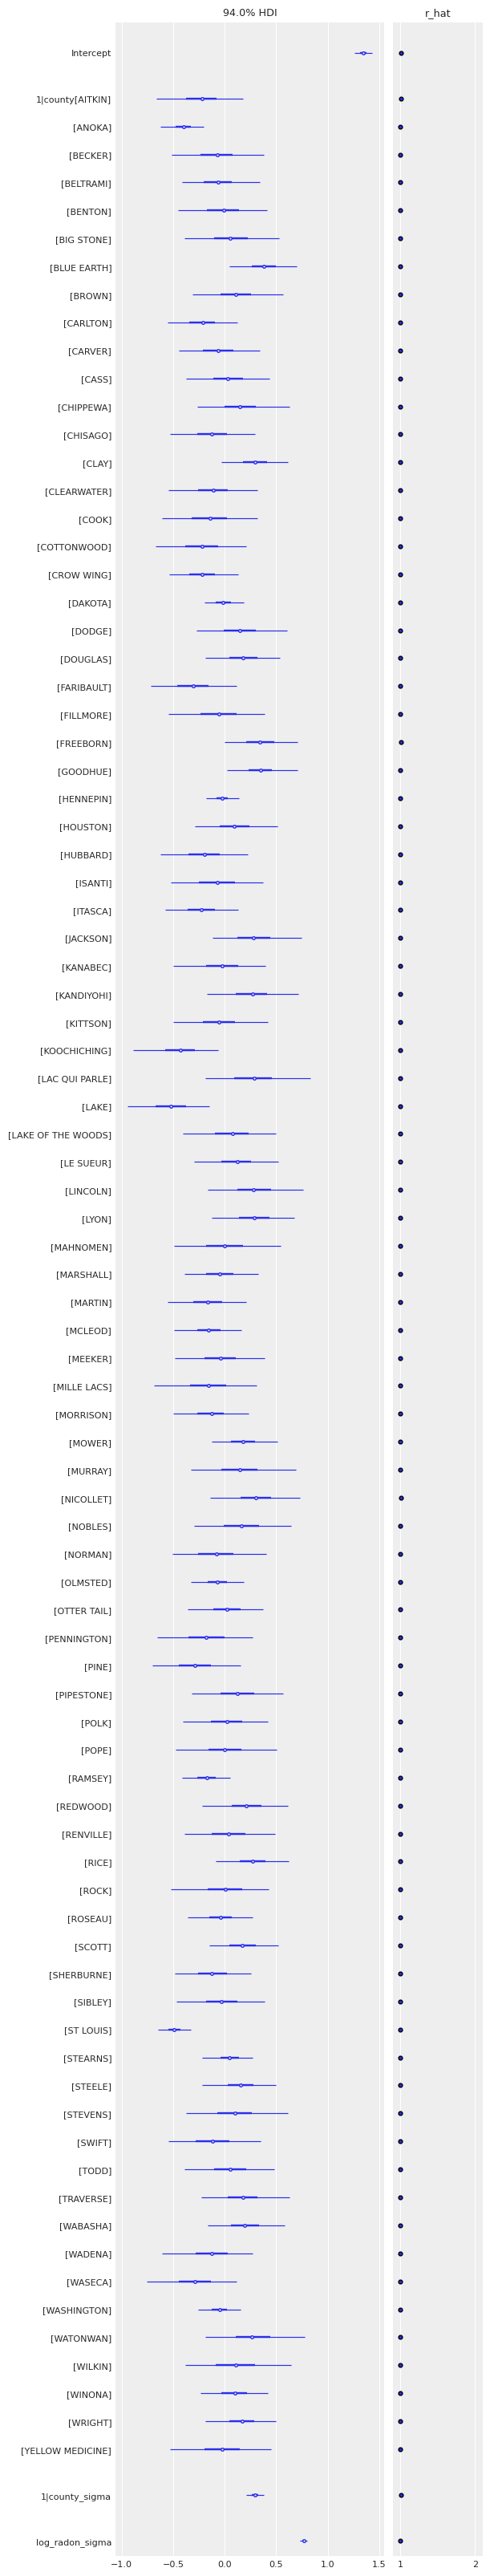

In [33]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Let us now compare the posterior predictive mean against the observed data at county level.

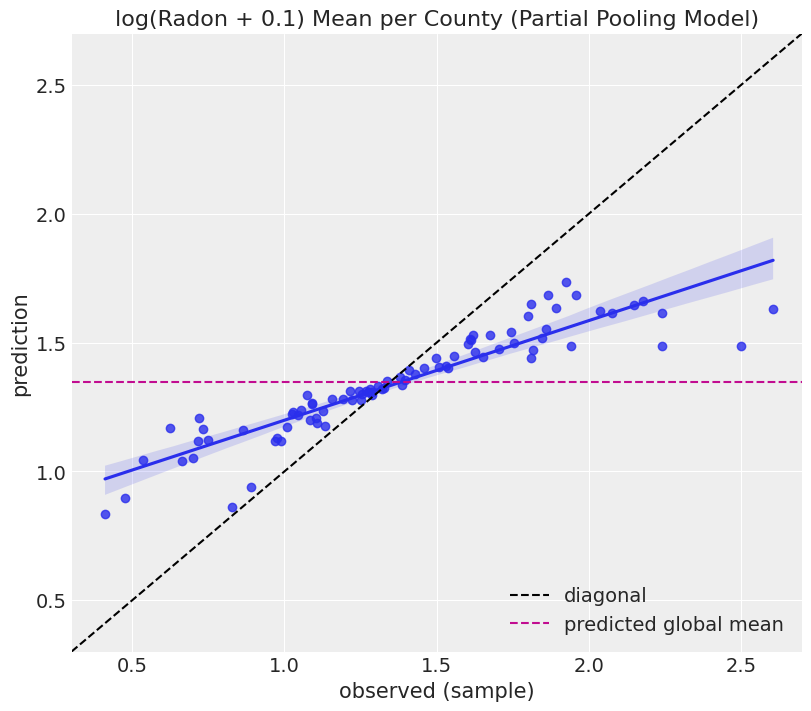

In [34]:
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# Stack chains and draws. pps stands for posterior predictive samples
pps = partial_pooling_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

pps_df = pd.DataFrame(data=pps).assign(county=df["county"])
y_pred = pps_df.groupby("county").mean().mean(axis=1)
y_sample = df.groupby("county")["log_radon"].mean()

fig, ax = plt.subplots(figsize=(8, 7))
sns.regplot(x=y_sample, y=y_pred, ax=ax)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(y=y_pred.mean(), color="C3", linestyle="--", label="predicted global mean")
ax.legend(loc="lower right")
ax.set(
    title="log(Radon + 0.1) Mean per County (Partial Pooling Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.3, 2.7),
    ylim=(0.3, 2.7),
);

Note that in this case the points are not concentrated along the diagonal (as it was the case for the unpooled model). The reason is that in the partial pooling model the hyperprior shrinks the predictions towards the global mean.

**What does _partial pooling_ exactly mean here?**

We said the first model we built performed a **complete pooling** because estimates pooled observations regardless to which County they belong to. We could see that in the coefficients for the Floor variable. The estimate for each level was the sample mean for each level, plus prior smoothing, without making any special distinction to observations from different Counties.

Then, when we built our second model we said it performed **no pooling**. This was the opposite scenario. Estimates for effects involving a specific County were not informed at all by the information in the other Counties.

Now, we say this model performs **partial pooling**. Well, if we had **complete** pooling and **no** pooling, this must be some type of compromise in between.

In this model, we have a global intercept $\alpha$, which represents the mean of the response variable across all Counties. We also have group-specific intercepts $u_{j[i]}$ that represent deviations from the global mean specific to each County $j$. Thess group-specific intercepts are assigned a Normal prior centered at 0. The standard deviations of these priors are considered random, instead of fixed. Since they are random, they are assigned a prior distribution, which is a hyperprior in this case because it is a prior on top of a prior. And that hyperprior is the same distribution for all the County-specific intercepts. Because of that, these random deviations from the global mean are not completely independent. Indeed, the shared hyperprior is what causes the **partial pooling** in the model estimates. In other words, some information is shared between Counties when computing estimates for their effects and it results in a shrinkage towards the global mean.

Connecting what we've just said with the figure above we can see the **partial pooling is a compromise between complete pooling (global mean) and no pooling (diagonal)**.

### Varying intercepts with predictors


Next, we add the `floor` global feature (i.e. does not depend on the `county`) into the model above. 

#### Model

$$
y_{i} = \beta_{j[i]} + u_{k[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\beta_{j[i]} &= \text{Intercept for the Floor level } j \\
u_{k[i]} &= \text{Intercept specific to the County } k \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The only common effect in this model is the floor term $\beta_{j[i]}$

$$
\beta_{j[i]} \sim \text{Normal}(0, \sigma_\beta)
$$

where $\sigma_{\beta}$ is a positive constant that we set to $10$.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to $1$.

##### Group-specific effects
 
$$
\begin{array}{lr}
u_{k[i]} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85 
\end{array}
$$

where the hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau)

$$

and $\tau$ is a positive constant that we set to $1$.

**Notes** 

$\beta_{j[i]}$ and $u_{k[i]}$ look similar. The difference is that the latter is a hierarchical effect (has a hyperprior), while the former is not.

In [35]:
varying_intercept_priors = {
    "floor": bmb.Prior(name="Normal", mu=0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    formula="log_radon ~ 0 + floor + (1|county)",
    data=df,
    priors=varying_intercept_priors,
    noncentered=False
 )

varying_intercept_model

Formula: log_radon ~ 0 + floor + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [36]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


When looking at the graph representation of the model we still see the hierarchical structure for the `county` varying intercepts, but we do not see it for the `floor` feature as expected.

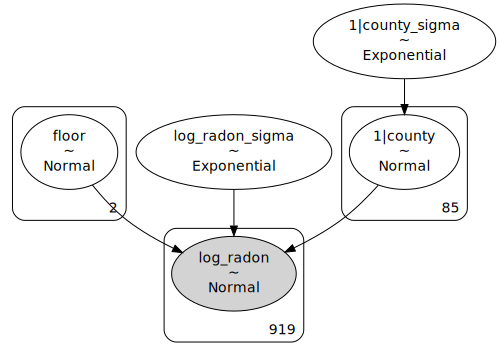

In [37]:
varying_intercept_model.graph()

Let us visualize the posterior distributions:

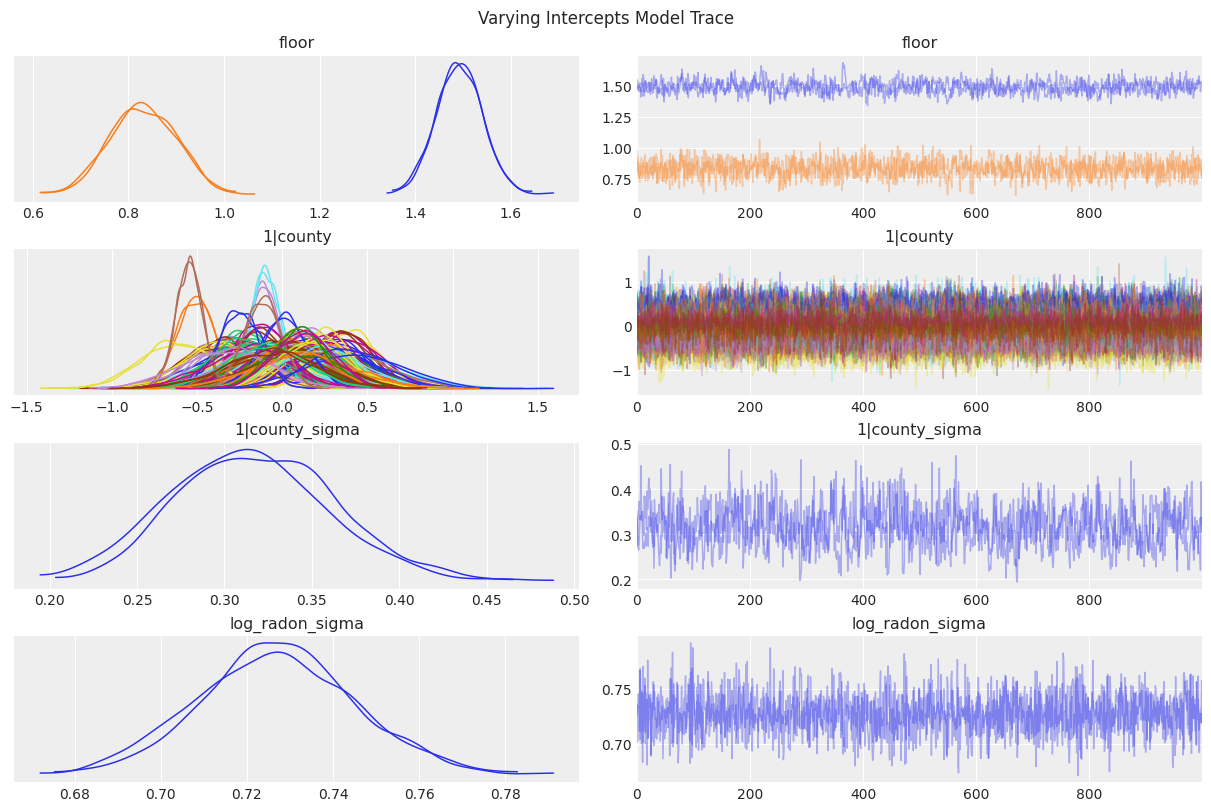

In [38]:
az.plot_trace(data=varying_intercept_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Varying Intercepts Model Trace");

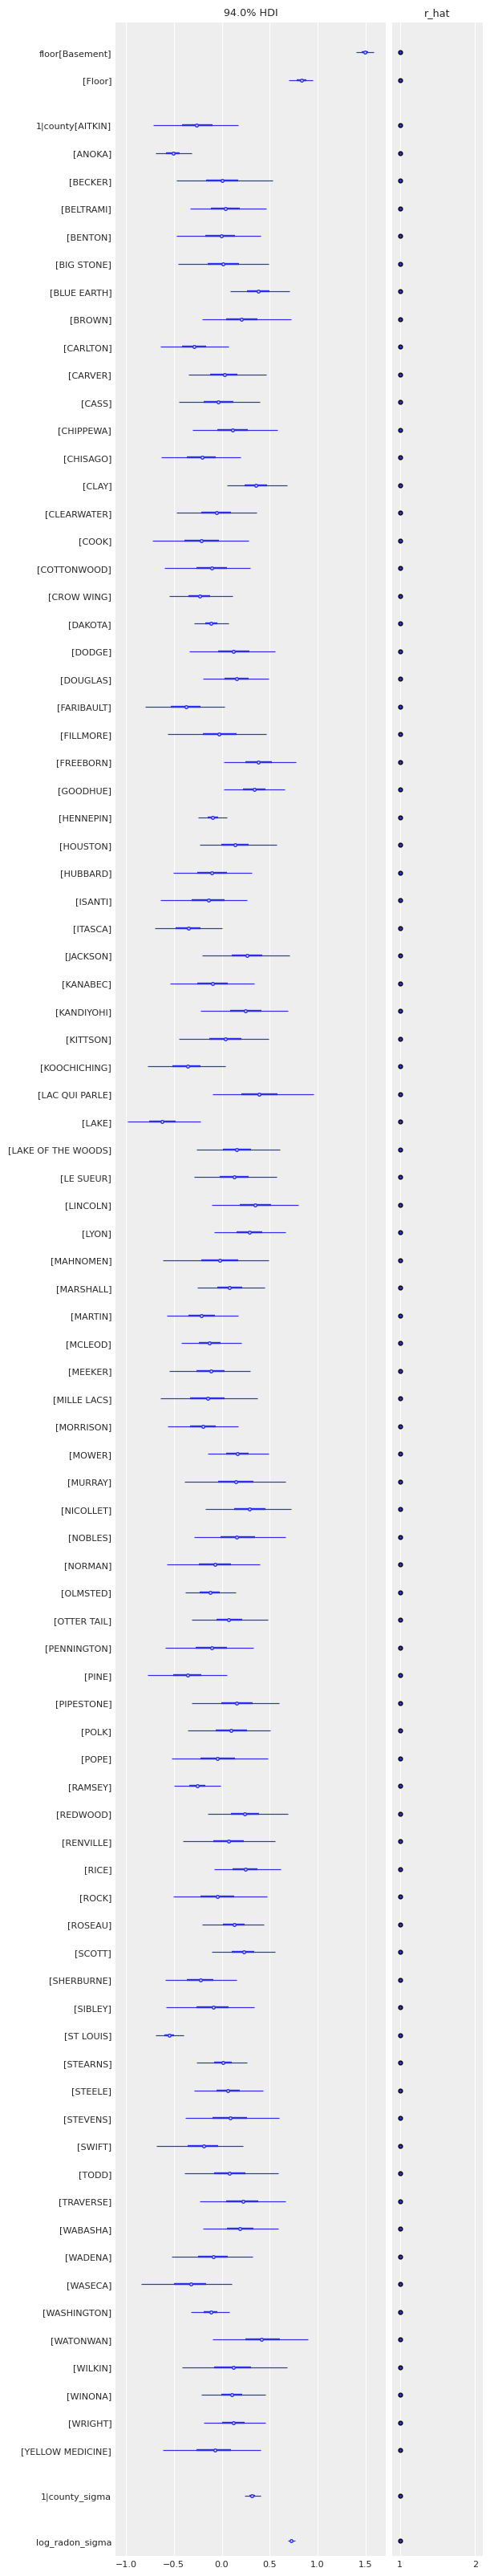

In [39]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying intercept and slope

**NOTE:** I'm not sure if the model `"log_radon ~ 1 + (1|county) + (floor|county)"` is well defined. Within county, the varying intercept and the sum of the varying "slopes" are collinear. A non-degenerate alternatives is  `"log_radon ~ 1 + (0 + floor|county)"`

Next we want to include a hierarchical structure in the Floor effect.

#### Model

$$
y_{i} = \alpha + \beta_{j[i]}+ u_{k[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the Radon measurement } i \\
\alpha &= \text{Intercept common to all measurements} \\
\beta_{j[i]} &= \text{Intercept deviation for the Floor level } j \\
u_{k[i]} &= \text{Intercept deviation for the County } k \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The only common effect in this model is the intercept $\alpha$

$$
\alpha \sim \text{Normal}(0, \sigma_\alpha)
$$

where $\sigma_\alpha$ is a positive constant that we set to $5$.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1.

##### Group-specific effects

We have two group-specific effects in this model. 

1. First the intercepts,

$$
\begin{array}{lr}
u_{k[i]} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85
\end{array}
$$

where the hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau_{u})

$$

and $\tau_{u}$ is a positive constant that we set to $1$.

2. The floor effects 

$$
\begin{array}{lr}
\beta_{k[j]} \sim \text{Normal}(0, \sigma_\beta) & \text{for all } j:1, \cdots, 85
\end{array}
$$

where the hyperprior is 

$$

\sigma_\beta \sim \text{Exponential}(\tau_{\beta})

$$

and $\tau_{\beta}$ is a positive constant that we set to $0.5$.


**Notes** 

* Both $\beta_{j[i]}$ and $u_{k[i]}$ are hierarchical now, they both have a hyperprior.


In this case the Bambi model specification is quite easy, namely `log_radon ~ (floor|county)`. This formula actually represent the following terms:
 - `Intercept`, which encodes the common effect $\alpha$.
 - `1|county` represent the varying intercepts.
 - `floor|county` represents the varying slopes.
 - `sigma` is the standard deviation of the errors. 


In [40]:
varying_intercept_slope_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ 1 + (0 + floor|county)",
    data=df,
    priors=varying_intercept_slope_priors,
    noncentered=False
 )

varying_intercept_slope_model

Formula: log_radon ~ 1 + (0 + floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5)

  Group-level effects
    floor|county ~ Normal(mu: 0, sigma: Exponential(lam: 0.5))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [41]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county, floor|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


In the graph representation of the model we can now see hierarchical structures both in the intercepts and the slopes.

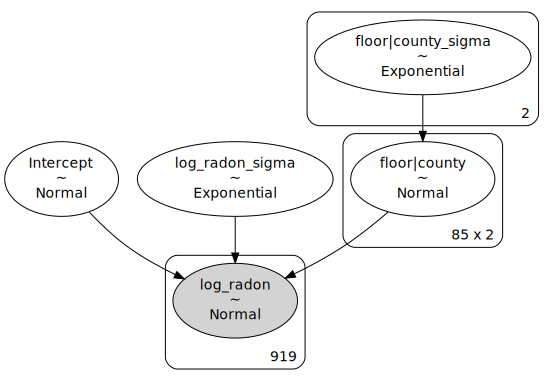

In [42]:
varying_intercept_slope_model.graph()

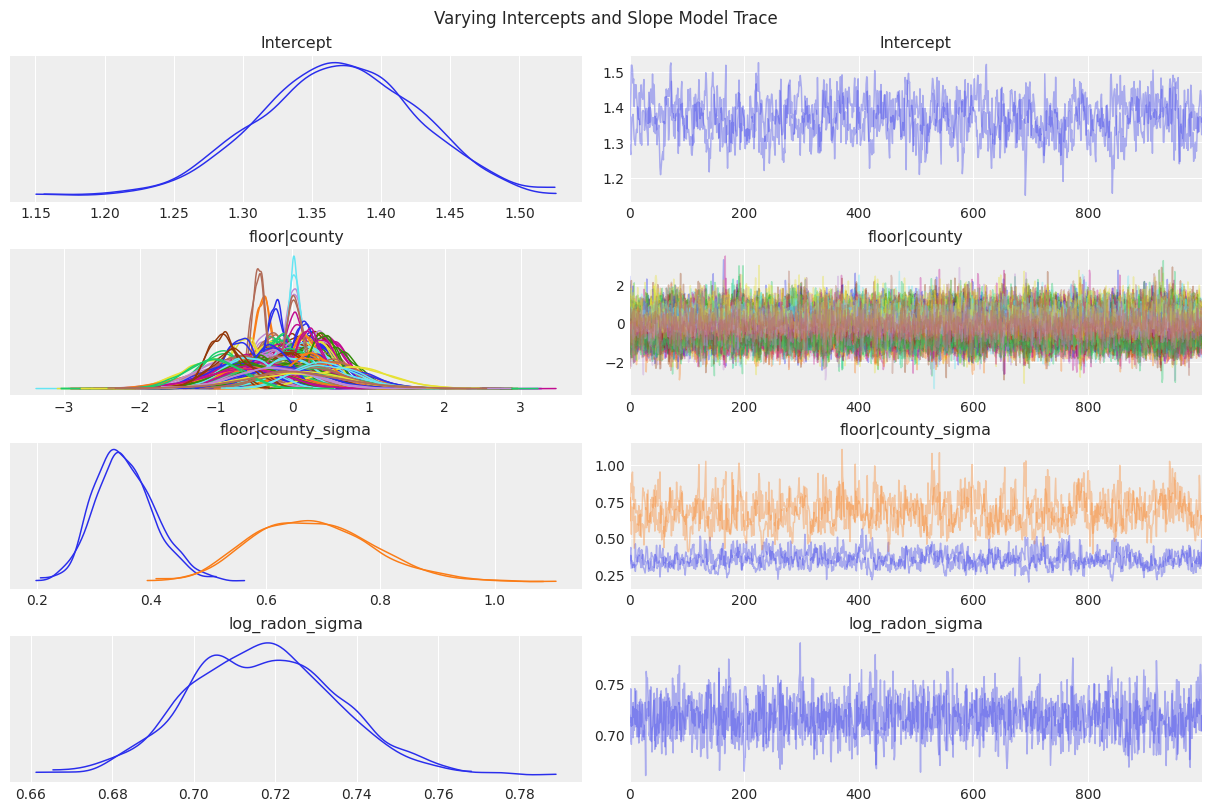

In [43]:
az.plot_trace(data=varying_intercept_slope_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Varying Intercepts and Slope Model Trace");

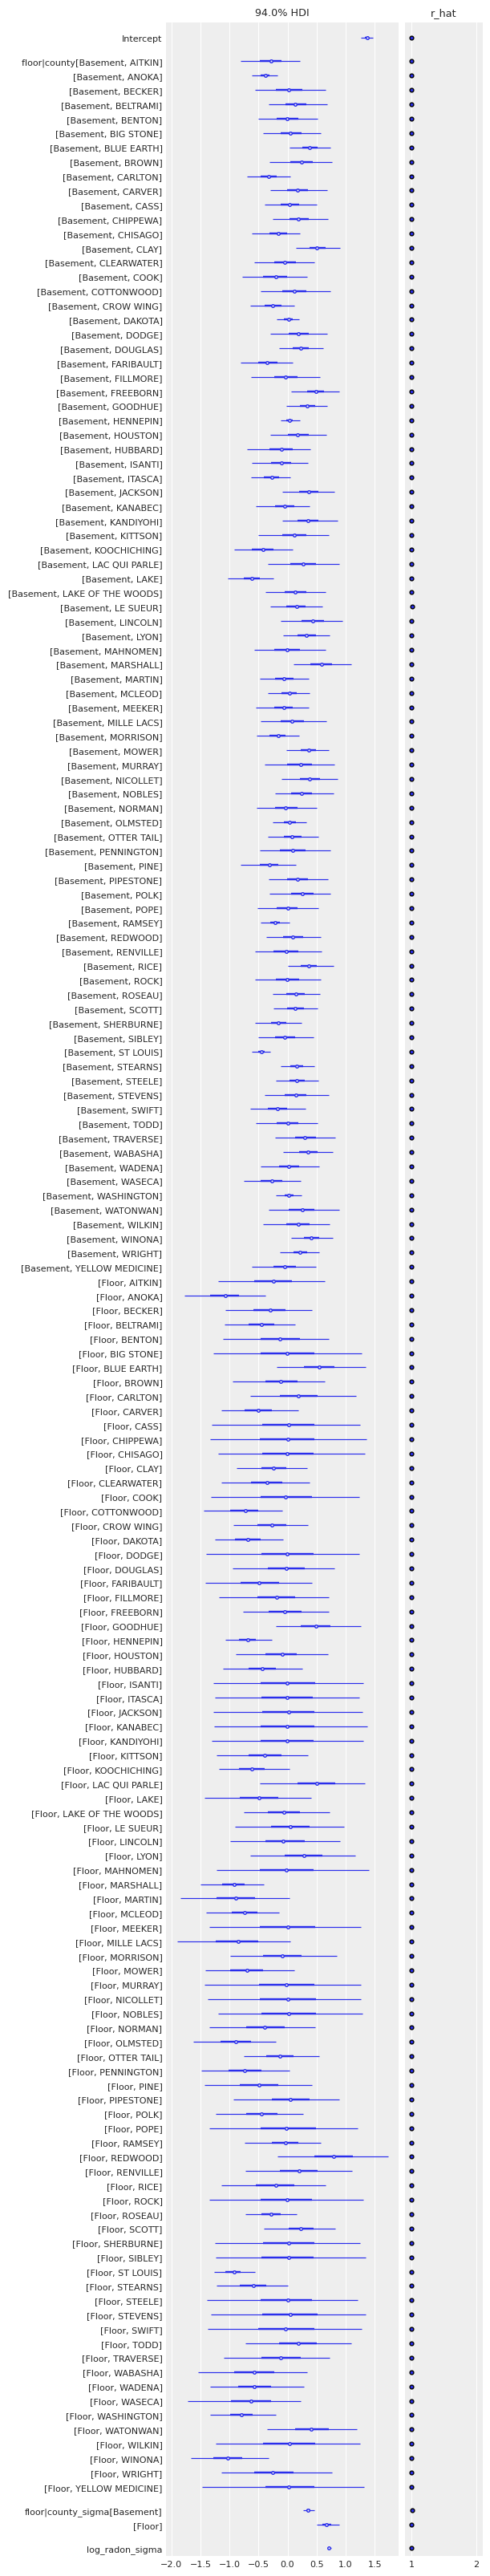

In [44]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Adding group-level predictors

*I don't know why the original post says "group level predictors" because this is not a predictor at the group level (as floor is, for example)*

We now want to consider the varying-intercepts model above and add a county-level predictor, namely the (log) uranium level.

#### Model

$$
y_{i} = \beta_{j[i]} + \xi_{k[i]}x_{k[i]} + u_{k[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\beta_{j[i]} &= \text{Intercept for the Floor level } j \\
\xi_{k[i]} &= \text{Effect for the County } k \: \text{at an uranium level} \: x_{k[i]} \\
u_{k[i]} &= \text{Intercept specific to the County } k \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The only common effect in this model is the floor term $\beta_{j[i]}$

$$
\begin{aligned}
\beta_{j[i]} \sim \text{Normal}(0, \sigma_\beta) \\
\xi_{j[i]} \sim \text{Normal}(0, \sigma_\xi)
\end{aligned}
$$

where $\sigma_{\beta} = \sigma_{\xi}$ is a positive constant that we set to $10$.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to $1$.

##### Group-specific effects
 
$$
\begin{array}{lr}
u_{k[i]} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85 
\end{array}
$$

where the hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau)

$$

and $\tau$ is a positive constant that we set to $1$.

In [45]:
covariate_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "log_u": bmb.Prior("Normal", mu=0, sigma=10),
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

covariate_model = bmb.Model(
    formula="log_radon ~ 1 + log_u + (0 + floor|county)",
    data=df,
    priors=covariate_priors,
    noncentered=True
 )

covariate_model

Formula: log_radon ~ 1 + log_u + (0 + floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5)
    log_u ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    floor|county ~ Normal(mu: 0, sigma: HalfNormal(sigma: [5.4958 5.4958]))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [46]:
covariate_results = covariate_model.fit(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county_offset, floor|county_sigma, log_u, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


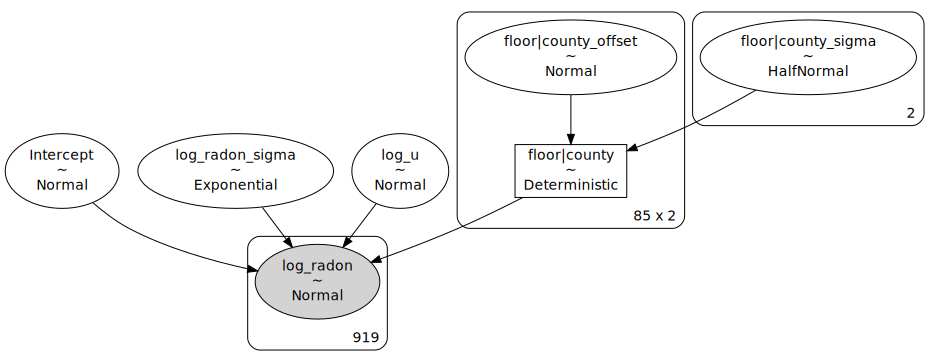

In [47]:
covariate_model.graph()

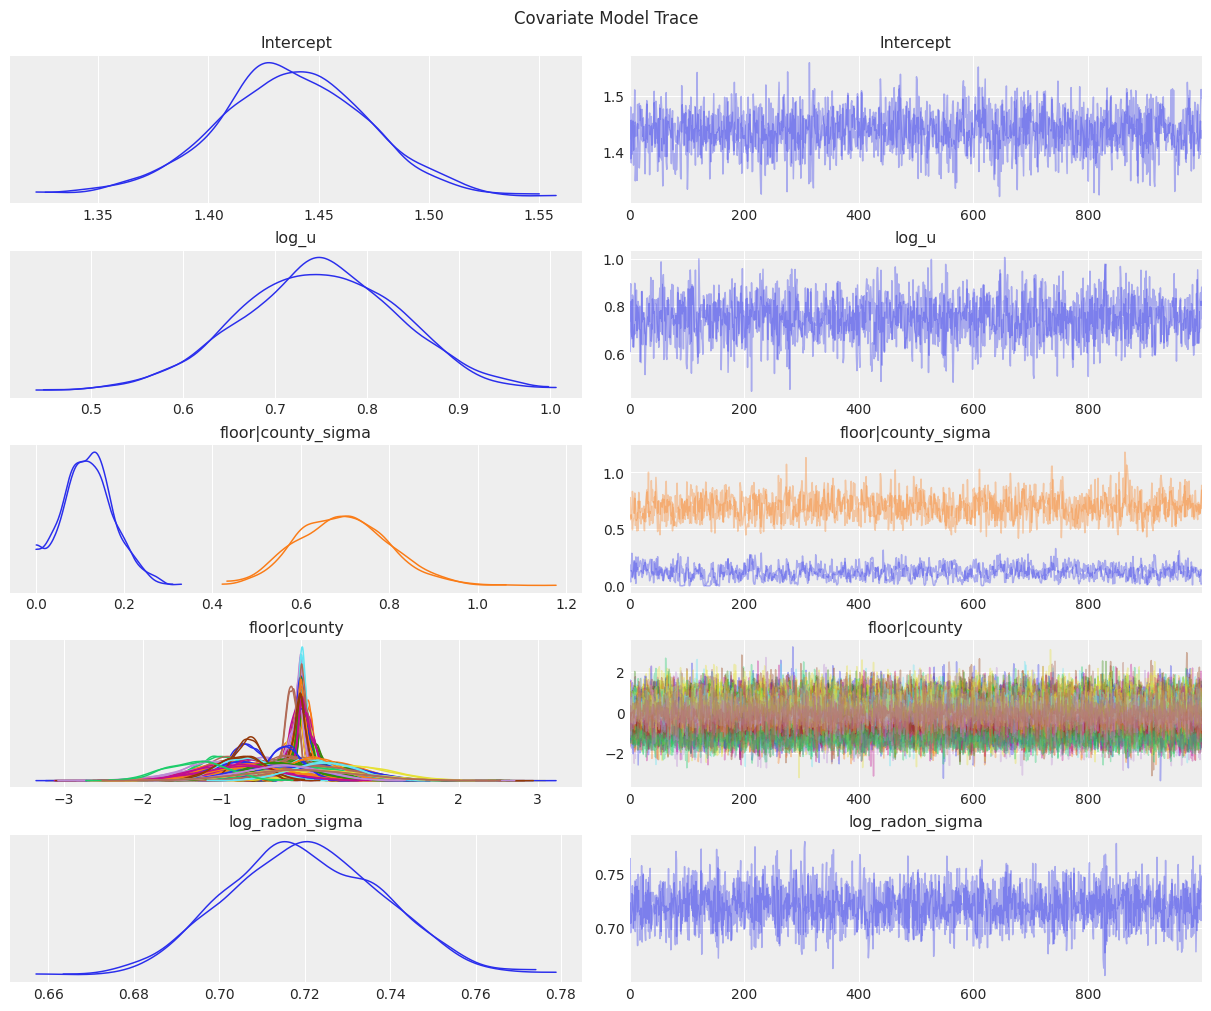

In [48]:
az.plot_trace(data=covariate_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Covariate Model Trace");

Let us now visualize the posterior distributions of the intercepts:

In [49]:
covariate_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "log_u": bmb.Prior("Normal", mu=0, sigma=10),
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

covariate_model = bmb.Model(
    formula="log_radon ~ 1 + floor + log_u + (1|county)",
    data=df,
    priors=covariate_priors
 )

covariate_results = covariate_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county_offset, 1|county_sigma, log_u, floor, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [50]:
# get log_u values per county
y_sample = df.groupby(["county"])["log_u"].mean().values

# compute the slope posterior samples
u_slope = covariate_results.posterior["log_u"].values[..., None] * y_sample

# compute the intercepts posterior samples
intercepts = (covariate_results.posterior["Intercept"] + covariate_results.posterior["1|county"]).values
y = (intercepts + u_slope).reshape(2000, n_counties).T

# reduce the intercepts posterior samples to the mean per county
mean_intercept = intercepts.mean(axis=2)[..., None] + u_slope

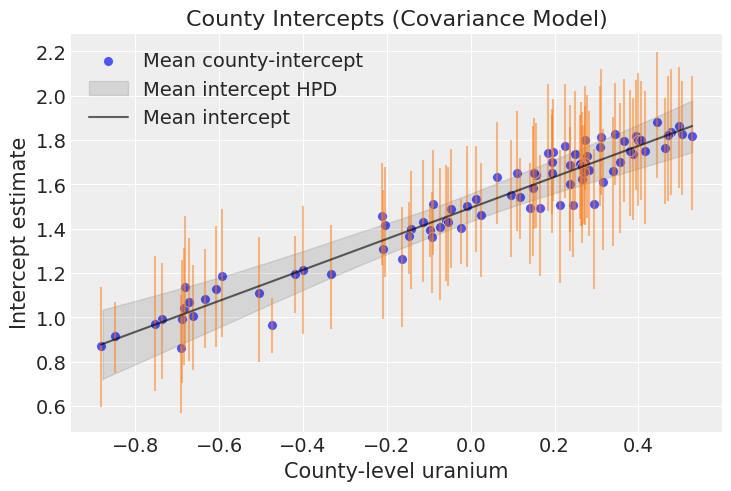

In [51]:
fig, ax = plt.subplots()

qts = np.quantile(y, q=[0.03, 0.96], axis=1)
sns.scatterplot(
    x=y_sample,
    y=y.mean(axis=1),
    alpha=0.8,
    color="C0",
    s=50,
    label="Mean county-intercept",
    ax=ax
)
ax.vlines(y_sample, qts[0], qts[1], color="C1", alpha=0.5)
az.plot_hdi(
    x=y_sample,
    y=mean_intercept,
    color="black",
    fill_kwargs={"alpha": 0.1, "label": "Mean intercept HPD"},
    ax=ax
)
sns.lineplot(
    x=y_sample,
    y=mean_intercept.reshape(2000, n_counties).mean(axis=0),
    color="black",
    alpha=0.6,
    label="Mean intercept",
    ax=ax
)
ax.legend(loc="upper left")
ax.set(
    title="County Intercepts (Covariance Model)",
    xlabel="County-level uranium",
    ylabel="Intercept estimate"
);

Let's consider a varying slope for `log_u` (i.e. to see if the slope for uranium concentration varies across counties).

In [52]:
covariate_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "log_u": bmb.Prior("Normal", mu=0, sigma=10),
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

covariate_model = bmb.Model(
    formula="log_radon ~ 1 + log_u + (0 + floor + log_u |county)",
    data=df,
    priors=covariate_priors,
    noncentered=True
 )

covariate_model

Formula: log_radon ~ 1 + log_u + (0 + floor + log_u |county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5)
    log_u ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    floor|county ~ Normal(mu: 0, sigma: HalfNormal(sigma: [5.4958 5.4958]))
    log_u|county ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.607))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [53]:
covariate_results = covariate_model.fit(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, log_u|county_offset, log_u|county_sigma, floor|county_offset, floor|county_sigma, log_u, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


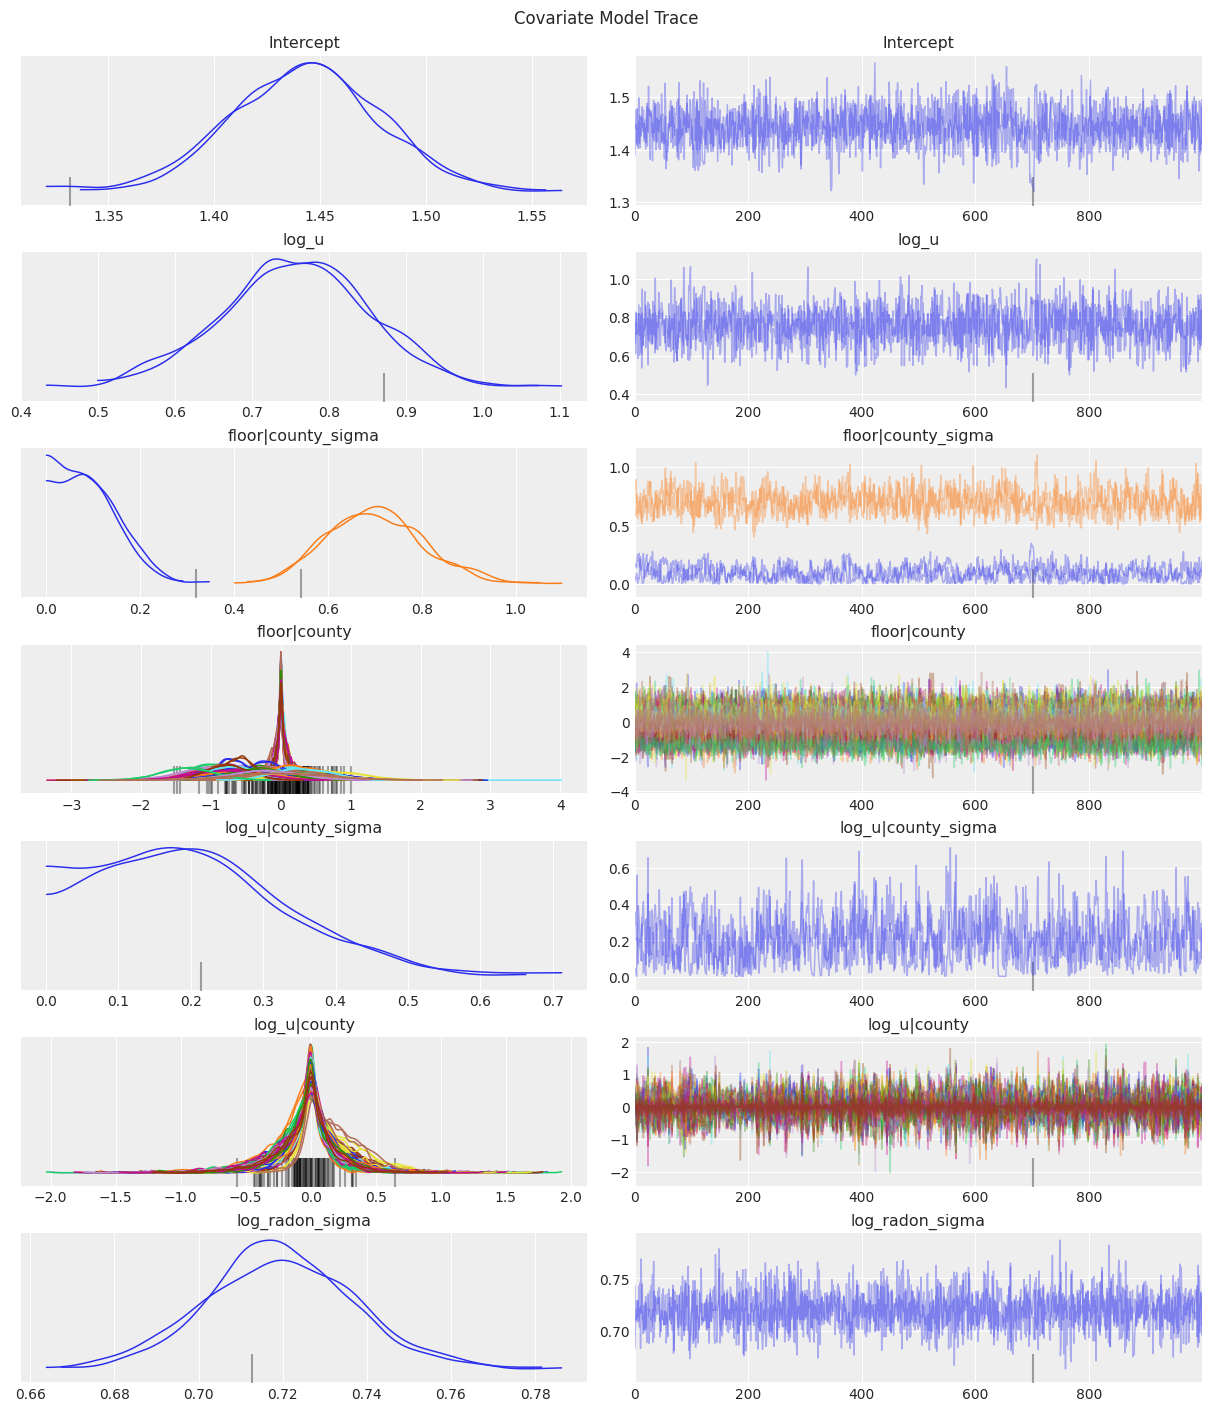

In [54]:
az.plot_trace(data=covariate_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Covariate Model Trace");

We can use [`az.compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) to compare and rank all the models.

In [55]:
dataset_dict = {
    "pooled": pooled_results,
    "unpooled": unpooled_results,
    "partial_pooling": partial_pooling_results,
    "varying_intercept": varying_intercept_results,
    "varying_intercept_slope": varying_intercept_slope_results,
    "covariate": covariate_results,
}

az.compare(dataset_dict=dataset_dict)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-

rank          loo       p_loo      d_loo    weight  \
varying_intercept           0 -1036.782956   48.655053   0.000000  0.421526   
covariate                   1 -1041.917651   68.730192   5.134695  0.474933   
varying_intercept_slope     2 -1051.774548   91.779606  14.991592  0.000000   
partial_pooling             3 -1083.889526   43.334237  47.106570  0.008195   
pooled                      4 -1090.051917    3.927576  53.268961  0.089653   
unpooled                    5 -1092.991512  144.782133  56.208556  0.005693   

                                se        dse  warning loo_scale  
varying_intercept        27.956356   0.000000    False       log  
covariate                31.259184   9.026015     True       log  
varying_intercept_slope  30.194676   7.815401     True       log  
partial_pooling          28.719916  10.788640     True       log  
pooled                   25.021233  10.667836    False       log  
unpooled                 29.964777  12.418738     True       log

--- 

## Summary 

Let us dig deeper into the model comparison for the pooled, unpooled, and partial pooling models. To do so we are generate predictions for each model ad county level, where we aggregate by taking the mean, and plot them against the observed values.

In [ ]:
# generate posterior predictive samples
pooled_model.predict(pooled_results, kind="pps")
unpooled_model.predict(unpooled_results, kind="pps")
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# stack chain and draw values
pooled_pps = pooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values
unpooled_pps = unpooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values
partial_pooling_pps = partial_pooling_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

# Generate predictions per county
pooled_pps_df = pd.DataFrame(data=pooled_pps).assign(county=df["county"])
y_pred_pooled = pooled_pps_df.groupby("county").mean().mean(axis=1)

unpooled_pps_df = pd.DataFrame(data=unpooled_pps).assign(county=df["county"])
y_pred_unpooled = unpooled_pps_df.groupby("county").mean().mean(axis=1)

partial_pooling_pps_df = pd.DataFrame(data=partial_pooling_pps).assign(county=df["county"])
y_pred_partial_pooling = partial_pooling_pps_df.groupby("county").mean().mean(axis=1)

# observed values
y_sample = df.groupby("county")["log_radon"].mean()

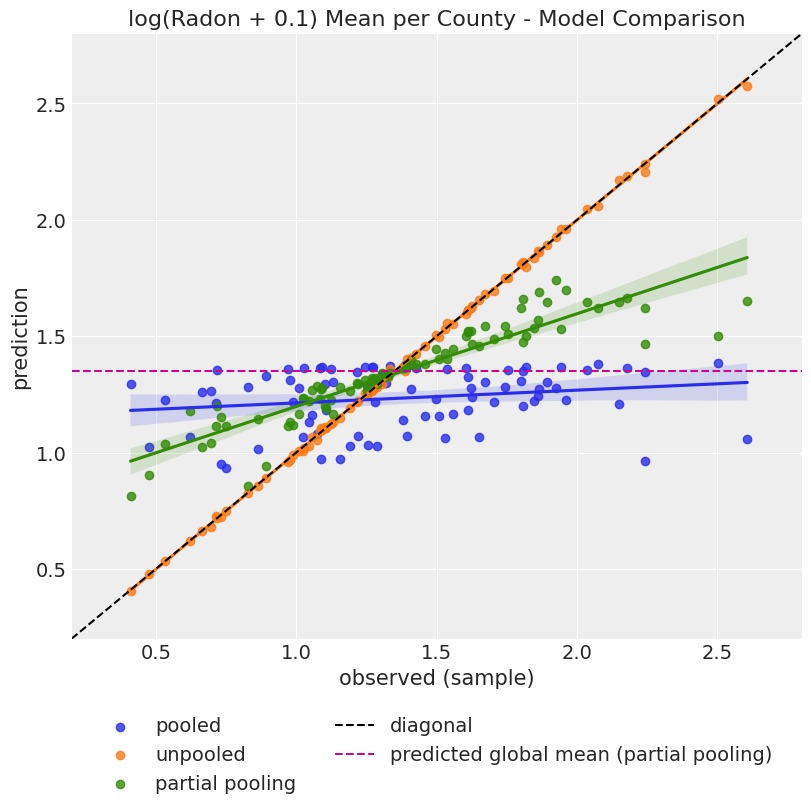

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.regplot(x=y_sample, y=y_pred_pooled, label="pooled", color="C0", ax=ax)
sns.regplot(x=y_sample, y=y_pred_unpooled, label="unpooled", color="C1", ax=ax)
sns.regplot(x=y_sample, y=y_pred_partial_pooling, label="partial pooling", color="C2", ax=ax)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(
    y=y_pred_partial_pooling.mean(), color="C3",
    linestyle="--", label="predicted global mean (partial pooling)"
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.set(
    title="log(Radon + 0.1) Mean per County - Model Comparison",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.2, 2.8),
    ylim=(0.2, 2.8),
);

- The pooled model consider all the counties together, this explains why the predictions do not vary at county level. This is represented by the almost-flat line in the plot above (blue).
- On the other hand, the unpooled model considers each county separately, so the prediction is very close to the observation mean. This is represented by the line very close to the diagonal (orange).
- The partial pooling model is mixing global and information at county level. This is clearly seen by how corresponding (green) line is in between the pooling and unpooling lines. 

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 23 2022

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.0

seaborn   : 0.11.2
arviz     : 0.11.4
numpy     : 1.21.5
sys       : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:50:56) 
[Clang 11.1.0 ]
pandas    : 1.3.5
bambi     : 0.7.1
pymc3     : 3.11.4
matplotlib: 3.5.1

Watermark: 2.3.0

